**Import Libraries and Load Data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Sequential

import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Load the MNIST dataset**

In [3]:
train = pd.read_csv("/content/drive/MyDrive/MNSIT_Database/train.csv")
test = pd.read_csv("/content/drive/MyDrive/MNSIT_Database/test.csv")

**Split the data into features (X) and labels (y)**

In [4]:
X = train.drop("label", axis=1).values
y = train["label"].values
X_test = test.values

**Data Preprocessing:**

* Reshape the data into 28x28 pixel images.
* Normalize the pixel values to a range of [0, 1].

In [5]:
X = X.reshape(-1, 28, 28, 1) / 255.0
X_test = X_test.reshape(-1, 28, 28, 1) / 255.0

**Split Data into Training and Validation Sets:**

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

**Data Augmentation**

In [7]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

**Learning Rate Scheduler**

In [8]:
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 5:
        return initial_lr
    else:
        return initial_lr * tf.math.exp(0.1 * (5 - epoch))

lr_scheduler = LearningRateScheduler(lr_schedule)


**Early Stopping**

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

**Build a Convolutional Neural Network (CNN):**

* CNNs are well-suited for image classification tasks.

In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train the Model:**

In [11]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/30
525/525 [==============================] - 145s 269ms/step - loss: 0.7441 - accuracy: 0.7692 - val_loss: 0.1619 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 2/30
525/525 [==============================] - 145s 276ms/step - loss: 0.2888 - accuracy: 0.9094 - val_loss: 0.0800 - val_accuracy: 0.9739 - lr: 0.0010
Epoch 3/30
525/525 [==============================] - 144s 275ms/step - loss: 0.2108 - accuracy: 0.9346 - val_loss: 0.0625 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 4/30
525/525 [==============================] - 138s 263ms/step - loss: 0.1804 - accuracy: 0.9435 - val_loss: 0.0586 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 5/30
525/525 [==============================] - 141s 268ms/step - loss: 0.1638 - accuracy: 0.9493 - val_loss: 0.0479 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 6/30
525/525 [==============================] - 145s 277ms/step - loss: 0.1458 - accuracy: 0.9541 - val_loss: 0.0557 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 7/30
525/525 [==========================

**Plot training history :**

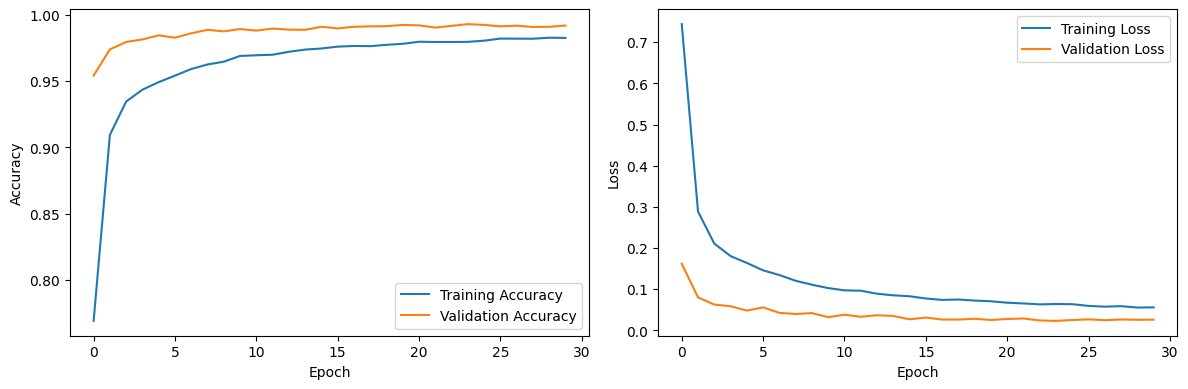

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Evaluate the Model on Validation Set :**

In [13]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

263/263 [==============================] - 9s 32ms/step - loss: 0.0259 - accuracy: 0.9919
Validation Loss: 0.025882156565785408, Validation Accuracy: 0.9919047355651855


**Plot training history :**

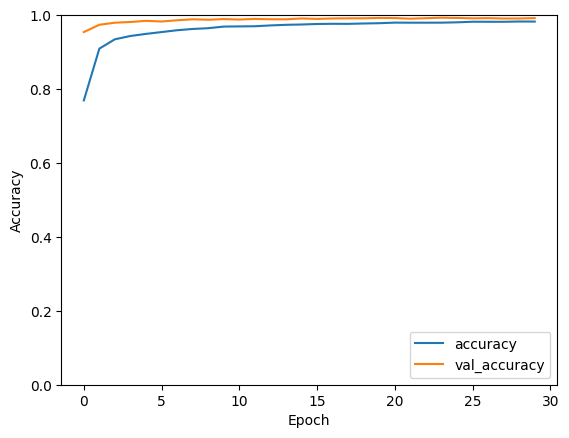

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

**Make Predictions:**

In [15]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)


875/875 [==============================] - 30s 34ms/step


**Create a Submission File:**

In [16]:
submission = pd.DataFrame({'ImageId': np.arange(1, len(y_pred_labels) + 1), 'Label': y_pred_labels})
submission.to_csv("submission.csv", index=False)

**Visualize some sample predictions :**

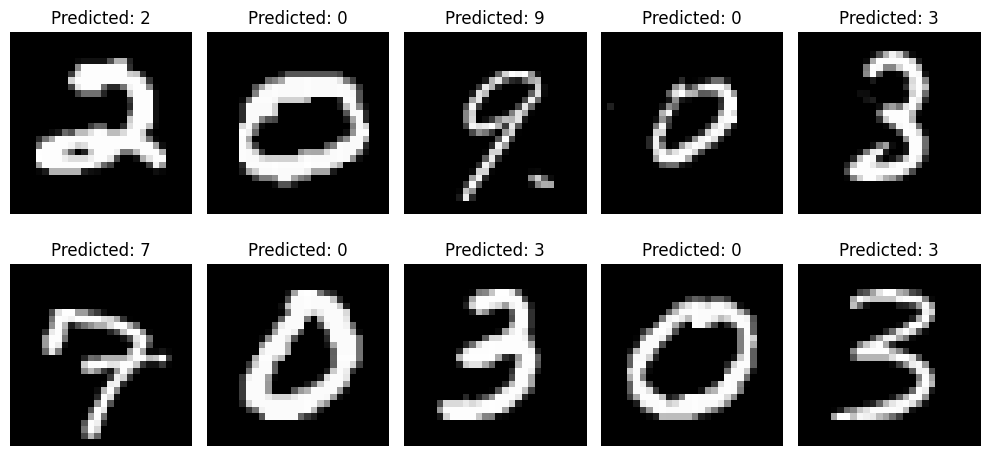

In [17]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {y_pred_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()